In [16]:
import pickle 
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from matplotlib import animation
from sklearn.utils import shuffle
from FNO2D import FNO2d, H1Loss, DataLoader2D
from plot_utils import comp_dyn
import os
import matplotlib.pyplot as plt
%matplotlib inline
cwd = os.getcwd()

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [4]:
random_seed = 1997
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [5]:
ntrain=4000
ntest=6000
batchsize=20
epochs=300
scaling = 100000
frames1 = 0
frames2 = nt = 150
nx = 128
timestep=990*(300/nt)
modes1 = 75
modes2 = 64
width = 128
learning_rate = 0.0001
gamma = 1
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
video_idx = [1,2,3,4,5]
data_filename = 'data-gaussian-pulse-10000'
data_path = '/data/'+data_filename+'.pickle'
save_path = '/model/'+data_filename+'.pt'
videoname = '/result/'+data_filename+'-'
running_name = data_filename

test_path = '/p/project/hai_ml_xas/KaHei/double-well-new/data/data-gaussian-pulse-test.pickle'

In [6]:
def expect_value(density, x_max = 90*np.pi/180, x_min = -90*np.pi/180, nx = 128, nt=150):
    all_expect_pos = np.zeros(nt)
    dx = (x_max-x_min)/nx
    for i in range(nt):
        Expect_pos = 0
        for j, x in enumerate(x_grid):
            expected = x*(density[i][j])*dx
            Expect_pos += expected
        all_expect_pos[i] = Expect_pos
    return all_expect_pos

# Training function

## Train model

In [7]:
def train_model(model,train_loader,epochs,device, learning_rate=0.0001, gamma = 0.9):
    H1 = H1Loss(d=2, fix_x_bnd=True, fix_y_bnd=True, fix_z_bnd=True)
    H1_phy = H1Loss(d=1, fix_x_bnd=True, fix_y_bnd=True, fix_z_bnd=True)
    learning_rate = learning_rate
    scheduler_step = 30
    scheduler_gamma = gamma
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    train_loss=[]

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    end.record()
    
    for e in range(epochs):
        train_mse = 0
        train_h1 = 0
        phy_loss = 0
        model.train()        
        for x,v,y in train_loader:
            x = x.to(device).float()
            y = y.to(device)
            optimizer.zero_grad()
            
            out = model(x).view(y.shape[0],y.shape[1],y.shape[2],y.shape[3])
            mse = F.mse_loss(out, y, reduction='mean')
            h1 = H1(out, y)
            y_f = y[:,:,-1,:]
            out_f = out[:,:,-1,:]
            pl = H1_phy(out_f, y_f)
            
            h1.backward()
            optimizer.step()
            scheduler.step()
       
            train_mse += mse.item()
            train_h1 += h1.item()
            phy_loss += pl.item()
        
        train_mse/= ntrain
        train_h1 /= ntrain    
        phy_loss /= ntrain

        if (e%10==0):
            print(e, '      ', train_h1, train_mse, phy_loss)
        
        if e == epochs-1:
            print(e, '      ', train_h1, train_mse, phy_loss)
            print('Training is done.')
        
        train_loss.append([train_h1,train_mse])    
    
    torch.cuda.synchronize()

    print()
    print('total running time (GPU): ', start.elapsed_time(end)/(1000*60), 'min')
    return train_loss

## Training, prediction and saving function

In [8]:
def trainNsave(data_path, save_path, videoname, ntrain=900,ntest=100,timestep=990,batchsize=20,epochs=30, modes1=20, modes2=20, width=20,
               device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), save=True, scaling = 100000, frames1 = 0, frames2 = 300, learning_rate = 0.0001, gamma=0.9, video_idx = [0,5,10,15]):
    print('Training: ', running_name)
    with open(data_path, 'rb') as handle:
        data_dict = pickle.load(handle)

    V=data_dict.get('V')
    u0=data_dict.get('u0')
    U_real=data_dict.get('U_real')
    gridx=data_dict.get('gridx')
    gridt=data_dict.get('gridt')
        
    x=torch.view_as_complex(U_real.contiguous())
    dens=(x.abs())**2
    dens = torch.stack([dens], dim=1)
    u0, dens, V = shuffle(u0, dens, V, random_state=0)
    dataset=DataLoader2D(u0,dens,V,timestep, scaling, frames1, frames2)

    train_loader = dataset.make_loader(gridx,gridt,ntrain, batchsize, start=0, train=True)
    test_loader = dataset.make_loader(gridx,gridt,ntest, batchsize, start=ntrain, train=False)

    model = FNO2d(width=width, modes1=modes1, modes2=modes2, lifting_input = 4, output_channel = 1)
    model = model.to(device)
    
    print('Training...')
    print('epochs             H1              MSE            Boundry H1 Loss')
    l1 = train_model(model,train_loader,epochs,device,learning_rate=learning_rate, gamma=gamma)

    model.eval()
    V_out=[]
    pred_out=[]
    true_out=[]
    H1 = H1Loss(d=2)
    test_h1 = 0.0
    test_mse = 0.0
    print()
    print('Testing...')
    with torch.no_grad():
        for i, (x,v,y) in enumerate(test_loader):
            x = x.to(device).float()
            y = y.to(device)
            out = model(x).view(y.shape[0],y.shape[1],y.shape[2],y.shape[3])
            mse = F.mse_loss(out, y, reduction='mean')
            h1 = H1(out, y)
            
            pred_out.append(out)
            V_out.append(v)
            true_out.append(y)
                
            test_mse += mse.item()
            test_h1 += h1.item()

        test_mse /= ntest
        test_h1 /= ntest
        print('Done with prediction')
        print('H1Loss: ', test_h1)
        print('mse: ', test_mse)
        print()

    if save:
        torch.save(model, save_path)
        print('saved model')
        x_min, x_max = -90*np.pi/180, 90*np.pi/180
        x_size = len(pred_out[0][0][0][0])
        x_grid = np.linspace(x_min, x_max, x_size)
        
        for i in video_idx:
            x=pred_out[0][i][0]
            x_true=true_out[0][i][0]
            v1=V_out[0][i]

            t=comp_dyn(x_min,x_max,x_grid,x.cpu(),x_true.cpu(),v1, frames = len(x),play=False,dt=0.024189)
            writervideo = animation.FFMpegWriter(fps=20)
            t.save(videoname + str(i) + '.mp4', writer = writervideo)
            print("saved video " + str(i))
        
        print('Done!')
        return pred_out, V_out, true_out, l1, model
    else:
        print('Done!')
        return pred_out, V_out, true_out, l1, model

# Real training and saving process

In [9]:
%%time
pred_out, V_out, true_out, l1, model = trainNsave(data_path=data_path, save_path=save_path, videoname=videoname,
                                           ntrain=ntrain,ntest=ntest,epochs=epochs, modes1=modes1, modes2=modes2, width=width, batchsize=batchsize, 
                                           device=device, save=True, scaling = scaling, frames1 = frames1, frames2 = frames2, learning_rate=learning_rate, gamma=gamma, video_idx = video_idx)

Training:  data-gaussian-pulse-10000
input shape:  torch.Size([4000, 4, 150, 128])
output shape:  torch.Size([4000, 1, 150, 128])
Training...
epochs             H1              MSE            Boundry H1 Loss
0        0.8514142038822174 0.0292718895226717 0.9850066442489624
10        0.3795706087350845 0.0033570289984345436 0.5697412134408951
20        0.3073138498067856 0.0021221379190683367 0.46605721199512484
30        0.2763534963130951 0.0016964514162391424 0.4132550290822983
40        0.24613907152414322 0.001342022965895012 0.3697433695793152
50        0.22700768303871155 0.0011501870146021246 0.33609046137332915
60        0.2071133250594139 0.000954993290361017 0.3062017081975937
70        0.196638354241848 0.0008699090292211621 0.28640782552957533
80        0.1864115470647812 0.0008010535363573581 0.2686124175786972
90        0.17237618803977967 0.0006690177116543054 0.25071449875831603
100        0.16345692747831345 0.0005983207921963185 0.23828828114271164
110        0.157991

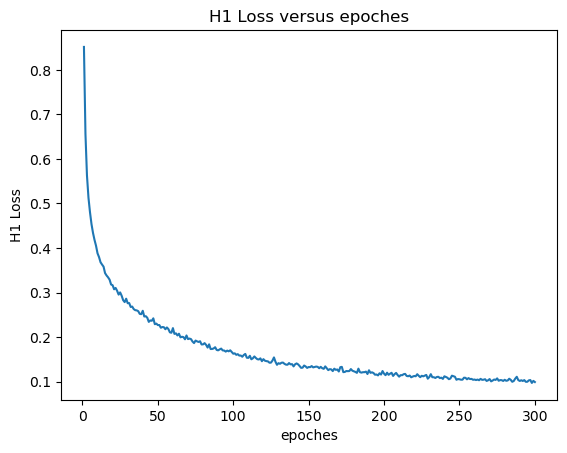

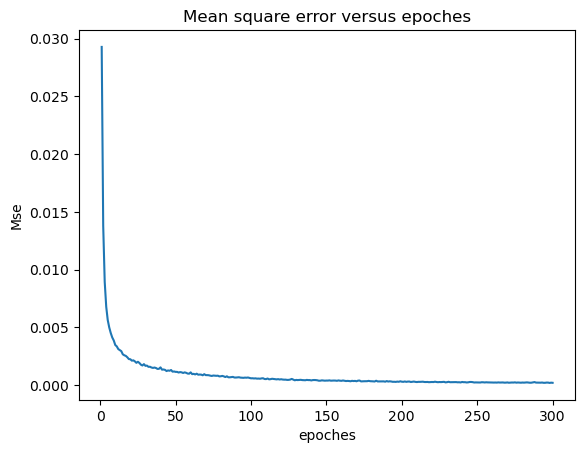

In [13]:
l1 = np.array(l1)
loss_h1 = l1[:,0]
loss_mse = l1[:,1]

plt.close()
plt.plot(np.linspace(1,epochs,epochs), loss_h1)
plt.title('H1 Loss versus epoches')
plt.ylabel('H1 Loss')
plt.xlabel('epoches')
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/FNO-density-h1loss.png')
plt.show()

plt.close()
plt.plot(np.linspace(1,epochs,epochs), loss_mse)
plt.title('Mean square error versus epoches')
plt.ylabel('Mse')
plt.xlabel('epoches')
plt.savefig('/p/project/hai_ml_xas/KaHei/double-well-new/pic/FNO-density-mse.png')
plt.show()

In [12]:
l1[:,0].shape

(300,)

# Testing with the highest score

In [7]:
params = {'sig': 1.5225027541551555, 't0': 0, 'beta': 0.1, 'A0': 0.019927467186978617, 'f0': 0.0948961733916297}

In [8]:
with open(test_path, 'rb') as handle:
        test_dict = pickle.load(handle)
        
V=test_dict.get('V')
u0=test_dict.get('u0')
U_real=test_dict.get('U_real')
gridx=test_dict.get('gridx')
gridt=test_dict.get('gridt')

In [9]:
x=torch.view_as_complex(U_real.contiguous())
dens=(x.abs())**2
dens = torch.stack([dens], dim=1)

In [10]:
dataset=DataLoader2D(u0,dens,V,timestep, scaling, frames1, frames2)

In [11]:
test = dataset.make_loader(gridx,gridt,1, batchsize, start=0, train=True)

input shape:  torch.Size([1, 4, 150, 128])
output shape:  torch.Size([1, 1, 150, 128])


In [12]:
modelname = '/model/data-gaussian-pulse-10000.pt'
model = torch.load(modelname)

In [13]:
pred_out = []
V_out = []
true_out = []

In [14]:
model.eval()
H1 = H1Loss(d=2)
test_h1 = 0.0
test_mse = 0.0
print()
print('Testing...')
with torch.no_grad():
    for i, (x,v,y) in enumerate(test):
        x = x.to(device).float()
        y = y.to(device)
        out = model(x).view(y.shape[0],y.shape[1],y.shape[2],y.shape[3])
        mse = F.mse_loss(out, y, reduction='mean')
        h1 = H1(out, y)
            
        pred_out.append(out)
        V_out.append(v)
        true_out.append(y)
                
        test_mse += mse.item()
        test_h1 += h1.item()

    print('Done with prediction')
    print('H1Loss: ', test_h1)
    print('mse: ', test_mse)
    print()


Testing...
Done with prediction
H1Loss:  0.1481720358133316
mse:  0.006499815732240677



In [17]:
x=pred_out[-1][0][0]
x_true=true_out[-1][0][0]
v1=V_out[-1][0]
x_min, x_max = -90*np.pi/180, 90*np.pi/180
x_size = len(pred_out[0][0][0][0])
x_grid = np.linspace(x_min, x_max, x_size)

t=comp_dyn(x_min,x_max,x_grid,x.cpu(),x_true.cpu(),v1, frames = len(x),play=False,dt=0.024189*2)
writervideo = animation.FFMpegWriter(fps=20)
t.save('/result/FNO_testing.mp4', writer = writervideo)
print("saved video ")

saved video 
